In [15]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "font.size": 20
})
# src modules
from input import IGraph, CoreSystem # import input objects (Quantum Circuit split into interaction graphs and multi-core configuration)
from optimization import QUBO

from qiskit.circuit.random import random_circuit

<b> Hardware graph </b>

The class CGraph holds 

In [16]:
cores = CoreSystem(ncores=3, capacity=2) # configure multi-core layout

# hortest distance matrix
cores.dmatrix # all-to-all layout s 
cores.dgridmatrix # 2x5 grid layout

{0: {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 8: 4, 7: 4, 9: 5},
 1: {1: 0, 0: 1, 3: 1, 2: 2, 5: 2, 4: 3, 7: 3, 9: 4, 6: 4, 8: 5},
 2: {2: 0, 0: 1, 3: 1, 4: 1, 1: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 4},
 3: {3: 0, 1: 1, 2: 1, 5: 1, 0: 2, 4: 2, 7: 2, 6: 3, 9: 3, 8: 4},
 4: {4: 0, 2: 1, 5: 1, 6: 1, 0: 2, 3: 2, 7: 2, 8: 2, 1: 3, 9: 3},
 5: {5: 0, 3: 1, 4: 1, 7: 1, 1: 2, 2: 2, 6: 2, 9: 2, 0: 3, 8: 3},
 6: {6: 0, 8: 1, 4: 1, 7: 1, 9: 2, 2: 2, 5: 2, 0: 3, 3: 3, 1: 4},
 7: {7: 0, 9: 1, 5: 1, 6: 1, 8: 2, 3: 2, 4: 2, 1: 3, 2: 3, 0: 4},
 8: {8: 0, 9: 1, 6: 1, 4: 2, 7: 2, 2: 3, 5: 3, 0: 4, 3: 4, 1: 5},
 9: {9: 0, 8: 1, 7: 1, 5: 2, 6: 2, 3: 3, 4: 3, 1: 4, 2: 4, 0: 5}}

<b> Example circuit </b>

We prepaired a small test example for you; try it out!

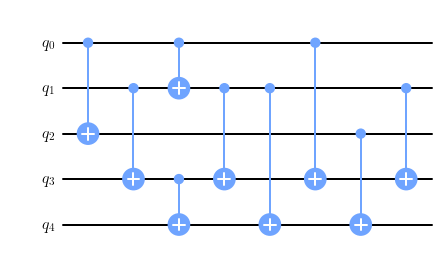

In [17]:
input_circuit = IGraph(fname='test') # build the interaction graph with test circuit (also, have a look into module InteractionGraph.py!)
input_circuit.qc.draw(output='mpl')

In [18]:
len(input_circuit.two_qubit_gates) #number of two-qubit gates present in the circuit

9

The test circuit is readily split into time slices, holding the interaction graphs (networkx.Graph objects):

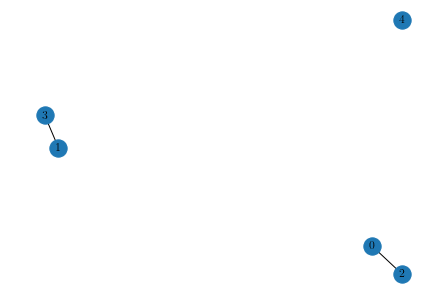

In [19]:
nx.draw(input_circuit.slices[0], with_labels=True)

An important ingredient for the QUBO are the graph laplacians for each slice:

In [20]:
Llist = input_circuit.get_laplacians() 
Llist[0]

array([[ 1,  0, -1,  0,  0],
       [ 0,  1,  0, -1,  0],
       [-1,  0,  1,  0,  0],
       [ 0, -1,  0,  1,  0],
       [ 0,  0,  0,  0,  0]])

Let's build the QUBO instance for the test circuit.

In [21]:
qubo_model = QUBO(input_circuit, cores, start=0, end=input_circuit.nslices, verbose=True) # initialize QUBO model

lam = 0.1 # try different lambda settings - can you notice a difference?
qubo_model.build(lam=lam) # build QUBO model
qubosolution = qubo_model.solve() # solve QUBO model 


5-qubit register circuit is split into 5 slices
3 cores of capacity 2
number of decision variables: 75 + 30 
Building successful.
Compile model ..
lam: 0.100000
Compilation successful.
Start solving ..
Potential solution found.


In [22]:
qubosolution.isvalid() # is the solution correct?

True

In [23]:
qubosolution.count_movements() # how many movements are needed?

10.0

Draw the mapping solution (this function is only recommended for small problem instances!)

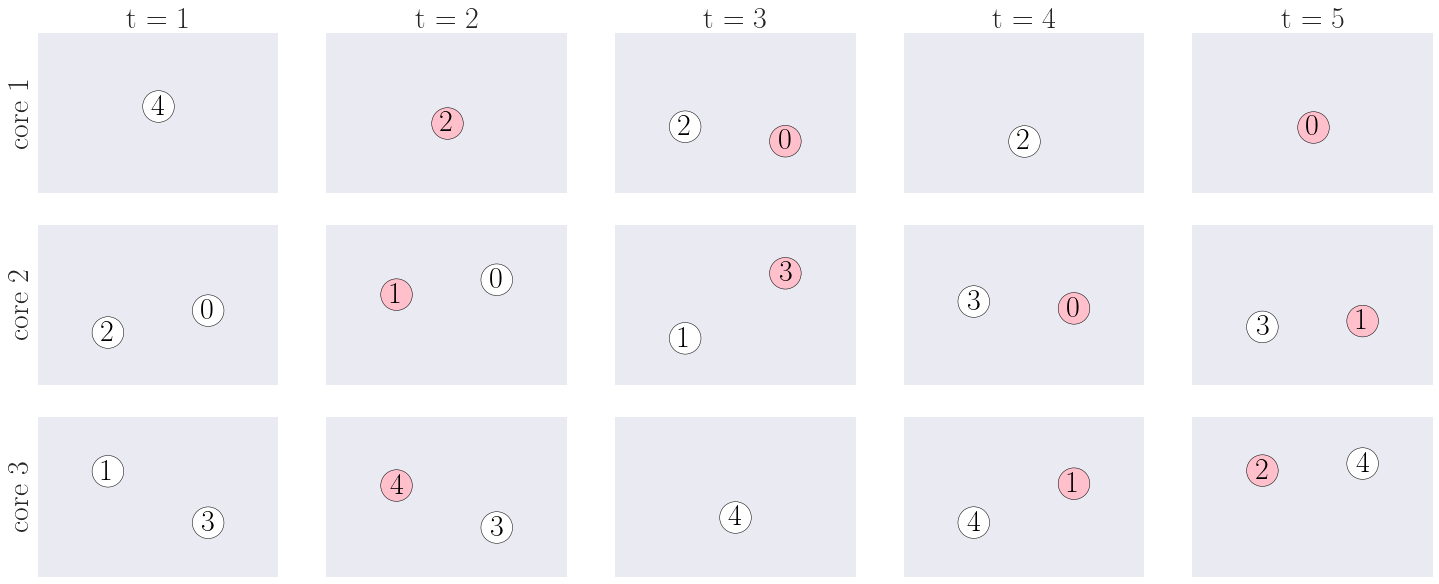

In [24]:
qubosolution.draw_mapping()

*You can acheck the size of the problem with*

In [25]:
qubo_model.nxvars

75

In [26]:
qubo_model.nyvars

30

<b> Example random </b>

Take a core system of your choice! Note: avoid higher than 100 physical qubits (e.g. 10 cores with capcity 10)

In [27]:
cgraph = CoreSystem(10,10)

Try to map a randomcircuit with 20 qubits (this will take ~30 sec)

In [28]:
qc = random_circuit(20,depth=4, max_operands=2, seed=42) #! this circuit can contain non-native gates, and will be decomposed --> the depth is not the depth of the mapped circuit!
input_circuit = IGraph(qc=qc)
print("Depth of decomposed circuit (into CX-gates): ", input_circuit.qc.depth()) #! this is the real depth
print("Number of CX-gates: ", len(input_circuit.two_qubit_gates))

qubo_model = QUBO(input_circuit, cgraph, start=0, end=input_circuit.nslices) # initialize QUBO model
qubo_model.build() # build QUBO model 
solution = qubo_model.solve() # solve QUBO model 

print("is valid: ",solution.isvalid())
print("movements: ", solution.count_movements())

Depth of decomposed circuit (into CX-gates):  25
Number of CX-gates:  58
is valid:  True
movements:  53.0
